In [1]:
#!/usr/bin/env python
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import pprint
import json

import numpy as np
import pandas as pd
import obspy
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
import time

from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"]= (15,15)
from matplotlib import rcParams, cycler
import matplotlib.colors as colors
from matplotlib import cm


import sys
import os
ISCOLAB = 'google.colab' in sys.modules

import random
import json
import pprint
from obspy import Stream, Trace, UTCDateTime
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3/'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
import json

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#%matplotlib notebook
helper = HelperFunctions()

In [2]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.05,
    'balance_non_train_set' : True,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)

2 2


Mapping redundancy: [--------------------------------------->] 100 %



In [3]:
earth_ds = full_ds[full_ds[:,1] == "earthquake"]
timeAug = TimeAugmentor(handler, earth_ds, loadData.seed)

In [4]:
def filter_by_year(ds, start_year, end_year):
    filtered_ds = []
    for path_label_red_index in ds:
        path, label, red_index = path_label_red_index
        year = path.split('/')[-1].split('-')[0]
        if start_year <= int(year) <= end_year:
            filtered_ds.append(path_label_red_index)
    return np.array(filtered_ds)

filtered_earth_ds = filter_by_year(earth_ds,  1993, 1994)

In [5]:
len(filtered_earth_ds)

73

In [6]:
m = 0

1
/media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/1993-08-26T19.24.32.293000Z.h5
1993-08-26 19:25:32.293000
2387
ORIGINAL


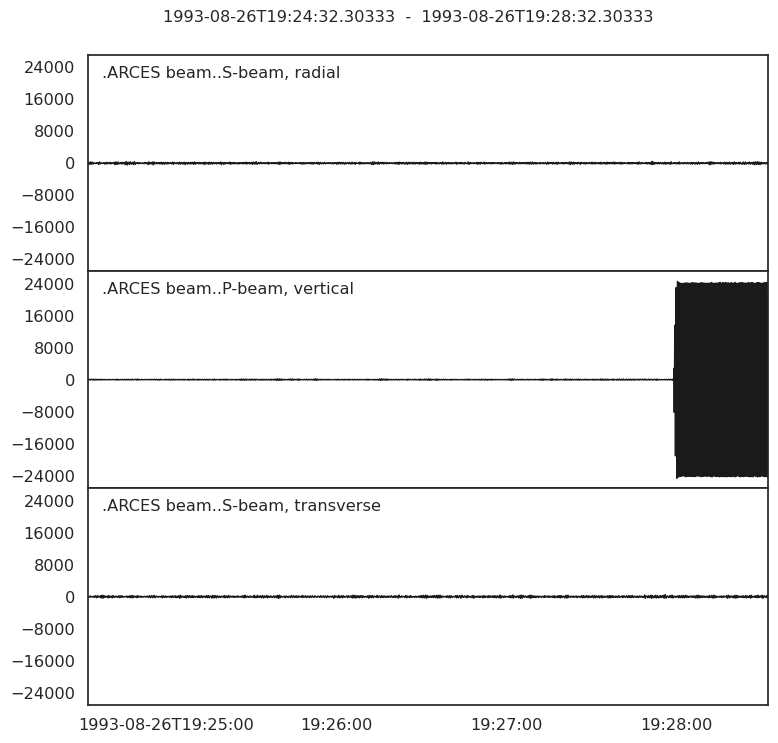

BANDPASS


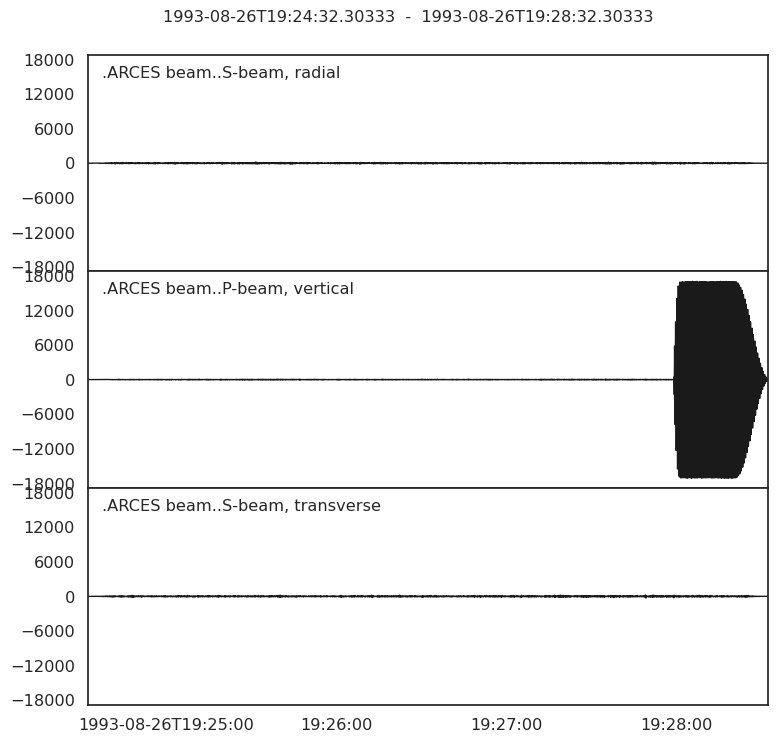

HIGHPASS


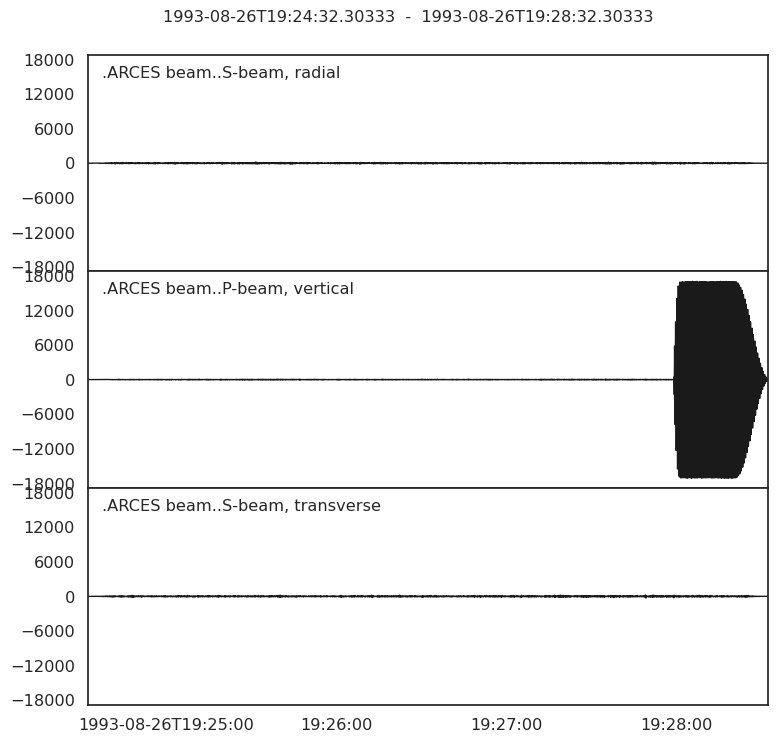

{   'analyst_pick_time': None,
    'az_to_arces': 37.47271239975236,
    'baz_to_arces': 237.1010041117286,
    'comments': [   {   'creation_info': {'author': 'general'},
                        'resource_id': 'smi:local/39b4f80d-a19e-49da-821c-ce8b5015a8ca',
                        'text': 'PROBABLY EARTHQUAKE'}],
    'dist_to_arces': 1357.8061777081846,
    'est_arrivaltime_arces': '1993-08-26 19:25:32.293000',
    'event_type': 'earthquake',
    'event_type_certainty': 'suspected',
    'magnitude_dist_ratio': 0.00206214999310584,
    'magnitude_sqrtdist_ratio': 0.07598697244065164,
    'magnitudes': [   {   'creation_info': {'agency_id': 'BER'},
                          'mag': 2.8,
                          'magnitude_type': 'MC',
                          'origin_id': 'smi:local/58f3edbb-58dd-4781-a912-3653c14e2fa3',
                          'resource_id': 'smi:local/7073e4c9-bf76-4831-b831-49de7d90d762',
                          'station_count': 20}],
    'origins': [   {   'c

In [7]:
m += 1
candidates = [1, 2, 6, 7, 8, 10]
filter_name = "highpass"
band_min = 2
band_max = 8
highpass_freq = 5

print(m)
earth_path = filtered_earth_ds[m][0]
#earth_path = '/media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/1993-08-26T19.24.32.293000Z.h5'
print(earth_path)
trace, info = handler.path_to_trace(earth_path)
trace_bandpass = handler.apply_filter(trace, info, "bandpass", highpass_freq = highpass_freq, band_min = band_min, band_max = band_max)
trace_highpass = handler.apply_filter(trace, info, "bandpass", highpass_freq = highpass_freq, band_min = band_min, band_max = band_max)

print(info['est_arrivaltime_arces'])
print(timeAug.find_initial_event_index(earth_path)[0])
print("ORIGINAL")
helper.plot_event(trace, info)
print("BANDPASS")
helper.plot_event(trace_bandpass, info)
print("HIGHPASS")
helper.plot_event(trace_highpass, info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(info)




### Observations:

 - Some events appear to contain multiple earthquakes (f.eks: /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2007-09-19T04.41.56.167000Z.h5, /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-04-15T19.20.09.574000Z.h5
 - Generally the onset of the earthquake is very weak, and after often over a minute later, the visually clear event occurs. This is very problematic wrt. the augmentation.
 - The labeled starttime is (for the ones I have seen) always at 1 minute after that start of the recording, and does not always correlate visually.
 

 

### Good candidates:

Events which start at the beginning of the waveform:
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-04-15T19.20.09.574000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-10-24T03.04.11.895000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-01-07T04.18.26.039000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2008-02-24T10.49.54.603000Z.h5


Events which start at the middle of the waveform:
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2013-08-16T16.01.20.125000Z.h5 (Starts after 1 minute, but the event of interest is most visible in the middle of the recording)

Events which start at the end of the waveform:
 
 
 #### Problematic datapoints:
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2013-08-18T09.00.06.112000Z.h5 (No clear event)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2009-09-10T13.44.59.544000Z.h5 (Labeled start is before the start of the waveform)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2009-09-14T00.42.14.329000Z.h5 (indistinguishable from noise)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2019-12-12T00.06.11.688000Z.h5 (Event of interest appears to occur waay later than labeled. This leads to that part being cut out.

 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-08-11T06.03.18.764000Z.h5 (too similar to noise)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2008-03-30T00.20.12.249000Z.h5 (Appears to start in the middle of an event. Does not seemingly contain noise during the first minute.)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-12-21T10.34.18.973000Z.h5 (Either mislabeled, or the labled event is not the most significant element of this recording)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2018-02-17T14.36.26.882000Z.h5 (Interesting event starts prior to the label)

 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2018-04-25T00.07.09.622000Z.h5 (Event appears to occur near the end of the recording, not even close to the labeled time.)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2013-07-02T15.59.07.043000Z.h5 (Surface wave arrives in the last minute (2.5 mins after labeled P-wave)

 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2012-07-14T13.11.15.500000Z.h5 (Surface wave appears to arrive prior to the labeled event. Could also be explained by the recording starting during an ongoing stronger earthquake)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2014-04-18T06.55.43.356000Z.h5 (Same issue as above)
 
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-07-12T11.46.07.144000Z.h5 (Onset prior to label)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2014-07-16T04.23.13.411000Z.h5 (Indistinguishable from noise)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2014-12-20T14.52.53.517000Z.h5 (Labeled event trumped by another event)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/1992-05-22T08.42.46.827000Z.h5 ("suspected" earthquake. Seems cut of and or has starttime mislabeled.)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2017-07-31T16.21.37.722000Z.h5 (Either mislabeled, or trumped by previus event)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/1993-03-06T01.29.45.803000Z.h5 (Strong signal likely an error)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/1994-08-20T14.04.50.656000Z.h5 (What is going on with the P-wave)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/1993-08-26T19.24.32.293000Z.h5 (Hardware failure?)

### Interesting datapoints
- /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2012-07-27T09.20.30.861000Z.h5 (Uncharacterstic in its strong onset)
- /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2016-09-22T09.30.37.711000Z.h5 (Large difference between filtered and unfiltered. Huge manifestations when unfiltered.)
- /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2006-08-09T07.42.00.079000Z.h5 (Clean, how I expected most of the data to look like)
- /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2017-09-29T19.22.12.310000Z.h5 (Clean when unfiltered, a mess when filtered)
- /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-06-09T16.57.12.583000Z.h5 (Same as above)


### Clean dps:

 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-04-06T04.49.00.713000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/1991-10-28T16.22.09.838000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-11-10T17.03.12.604000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-11-26T18.02.34.645000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-02-10T05.15.13.929000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2009-07-26T10.18.27.176000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2016-01-13T18.49.33.871000Z.h5 (clean when filtered)
 
### Benefits from filters:
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-02-01T03.59.41.134000Z.h5
 
### Suffers from filters:


### Filters:

 - Bandpass [2-8]
 - highpass [


In [8]:
i = 142

151
/media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/1993-08-26T19.24.32.293000Z.h5
1993-08-26 19:25:32.293000
2387
ORIGINAL


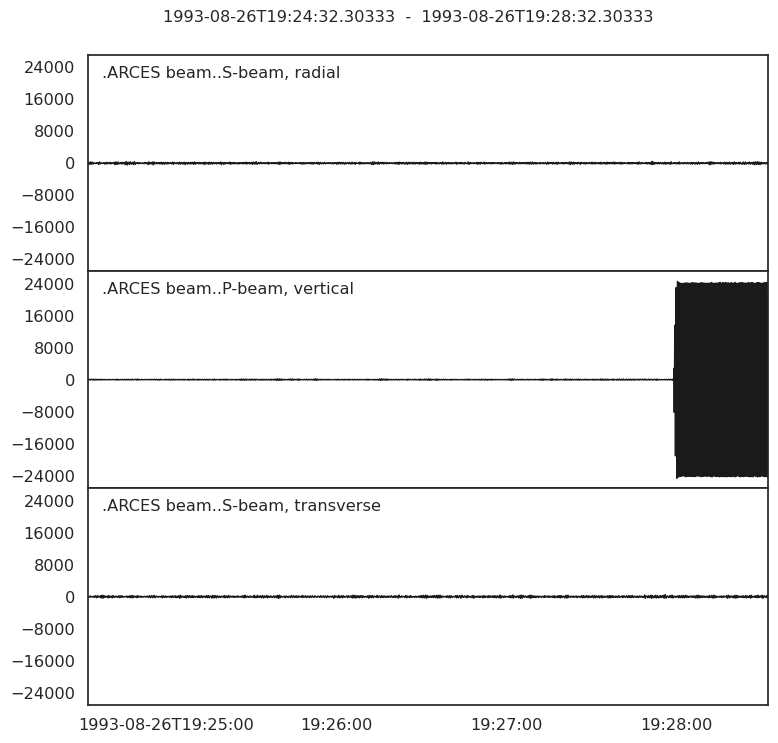

BANDPASS


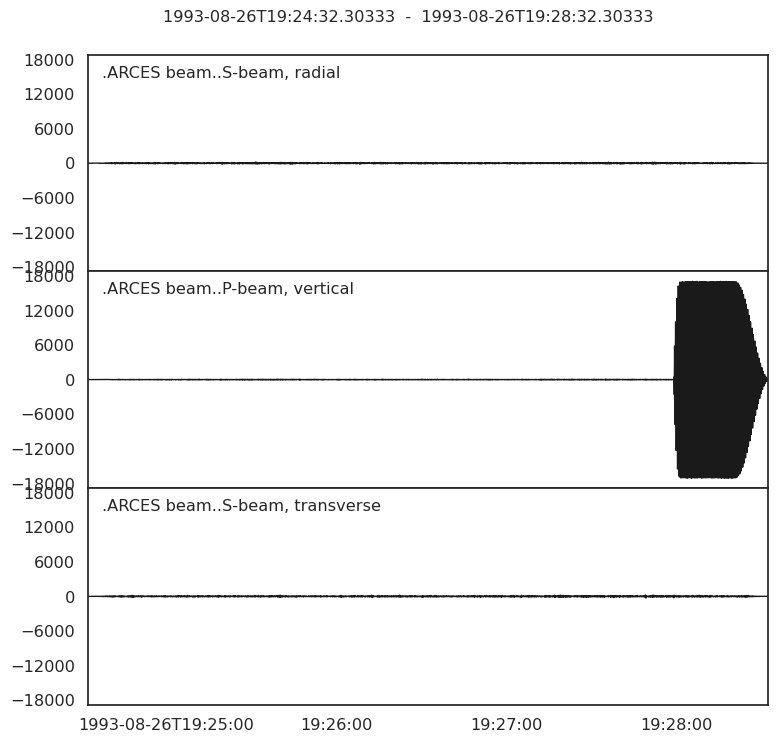

HIGHPASS


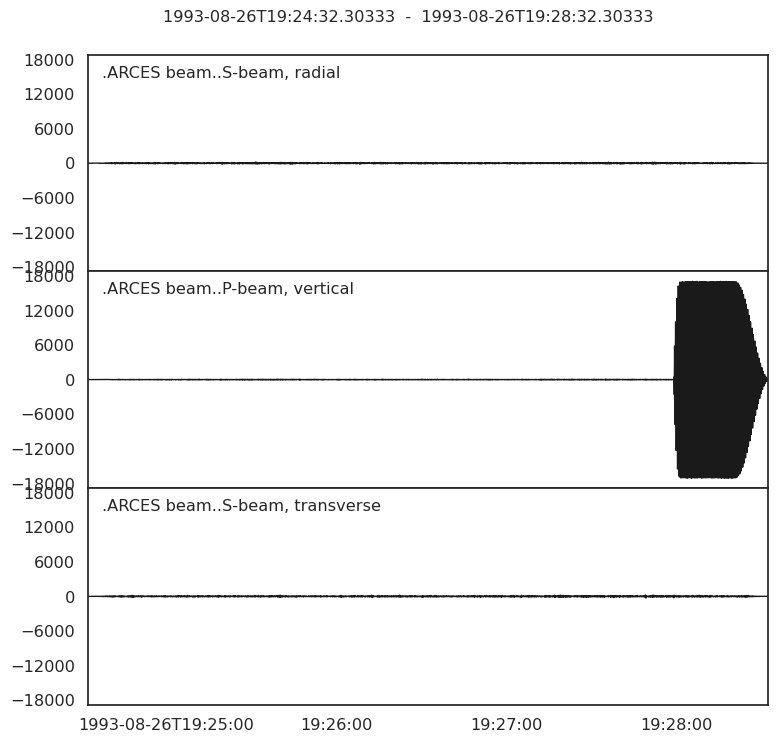

{   'analyst_pick_time': None,
    'az_to_arces': 37.47271239975236,
    'baz_to_arces': 237.1010041117286,
    'comments': [   {   'creation_info': {'author': 'general'},
                        'resource_id': 'smi:local/39b4f80d-a19e-49da-821c-ce8b5015a8ca',
                        'text': 'PROBABLY EARTHQUAKE'}],
    'dist_to_arces': 1357.8061777081846,
    'est_arrivaltime_arces': '1993-08-26 19:25:32.293000',
    'event_type': 'earthquake',
    'event_type_certainty': 'suspected',
    'magnitude_dist_ratio': 0.00206214999310584,
    'magnitude_sqrtdist_ratio': 0.07598697244065164,
    'magnitudes': [   {   'creation_info': {'agency_id': 'BER'},
                          'mag': 2.8,
                          'magnitude_type': 'MC',
                          'origin_id': 'smi:local/58f3edbb-58dd-4781-a912-3653c14e2fa3',
                          'resource_id': 'smi:local/7073e4c9-bf76-4831-b831-49de7d90d762',
                          'station_count': 20}],
    'origins': [   {   'c

In [25]:
i += 1
candidates = [1, 2, 6, 7, 8, 10]
filter_name = "highpass"
band_min = 2
band_max = 8
highpass_freq = 5

print(i)
earth_path = earth_ds[i][0]
earth_path = '/media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/1993-08-26T19.24.32.293000Z.h5'
print(earth_path)
trace, info = handler.path_to_trace(earth_path)
trace_bandpass = handler.apply_filter(trace, info, "bandpass", highpass_freq = highpass_freq, band_min = band_min, band_max = band_max)
trace_highpass = handler.apply_filter(trace, info, "bandpass", highpass_freq = highpass_freq, band_min = band_min, band_max = band_max)

print(info['est_arrivaltime_arces'])
print(timeAug.find_initial_event_index(earth_path)[0])
print("ORIGINAL")
helper.plot_event(trace, info)
print("BANDPASS")
helper.plot_event(trace_bandpass, info)
print("HIGHPASS")
helper.plot_event(trace_highpass, info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(info)




In [20]:
explo_ds = full_ds[full_ds[:,1] == "explosion"]
timeAug_explo = TimeAugmentor(handler, explo_ds, loadData.seed)

In [ ]:
j = 80

In [ ]:
j += 1
print(j)
candidates = [1, 2, 6, 7, 8, 10]
#filter_name = "highpass"
#filter_name = "bandpass"
filter_name = None
band_min = 2
band_max = 8
highpass_freq = 15

explo_path = explo_ds[j][0]
#earth_path = '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2012-01-21T10.10.24.865000Z.h5'
print(explo_path)
trace, info = handler.path_to_trace(explo_path)
if filter_name != None:
    #trace = np.array(trace)
    trace = handler.apply_filter(trace, info, filter_name, highpass_freq = highpass_freq, band_min = band_min, band_max = band_max)
print(info['est_arrivaltime_arces'])
print(timeAug.find_initial_event_index(explo_path)[0])
helper.plot_event(trace, info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(info)


#j = j-1


### Observations:

 - Appears to contain more "echo" than earthquakes, or multiple explosions at regular intervals. Likely not generally true
 

### Good candidates:
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2010-10-11T16.10.04.968000Z.h5 (Clean)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2018-04-30T10.12.58.603000Z.h5 (More like what I expect)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2008-08-16T11.29.27.911000Z.h5 (super clean)

### Good filtered candidates
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2002-09-12T03.33.23.858000Z.h5
 

### Highpass candidates:

 
 ### Problematic events:
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2013-06-10T14.03.22.128000Z.h5 (P-beam is off the charts, while the rest are not even close to the same magnitude)
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2002-12-03T12.36.16.994000Z.h5 (Some event occuring during the first minute)
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2016-06-01T10.42.13.807000Z.h5 (All beams are off the charts 
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2016-06-01T10.42.13.807000Z.h5 (same as above)
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2017-04-08T15.52.19.641000Z.h5 (Multiple peaks, indicating several explosions. Strange due to the increasing intensity of each peak.)
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2012-01-21T10.10.24.865000Z.h5 (Clean with filter, but not without)
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/1994-03-09T15.22.55.837000Z.h5 (REALLY BAD)
 

In [18]:
k = 81

86
/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/1994-03-09T15.22.55.837000Z.h5
1994-03-09 15:23:55.837000
2363
ORIGINAL


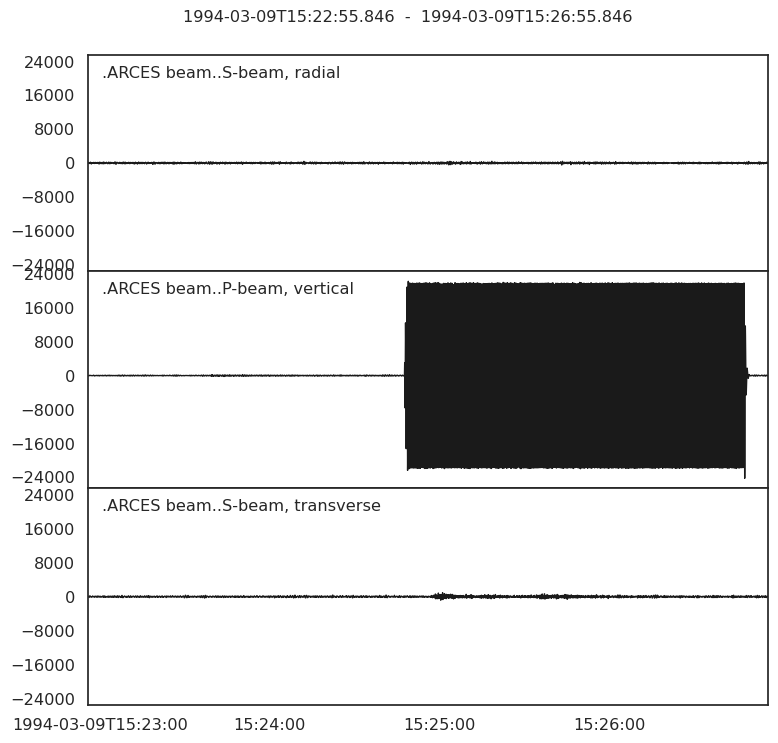

BANDPASS


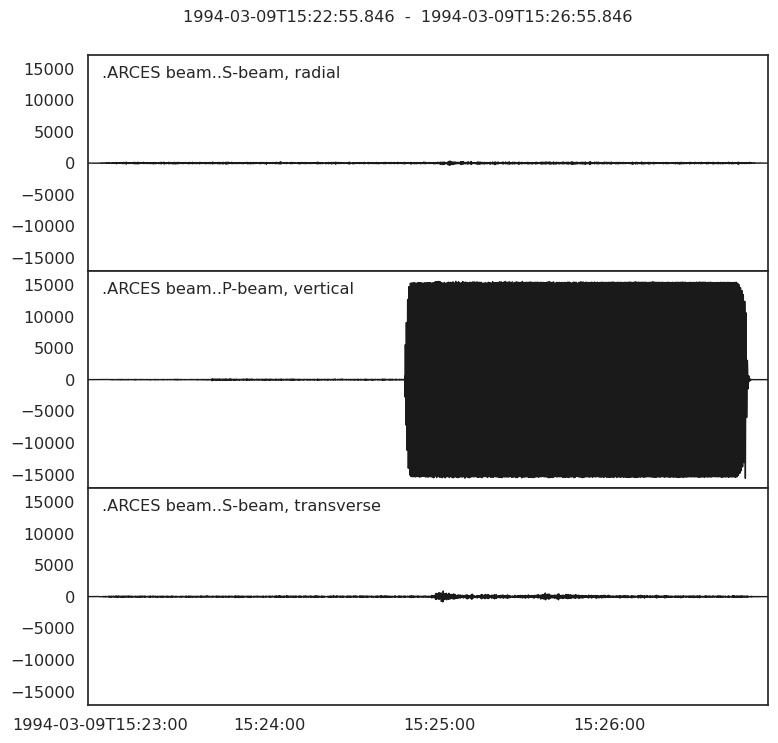

HIGHPASS


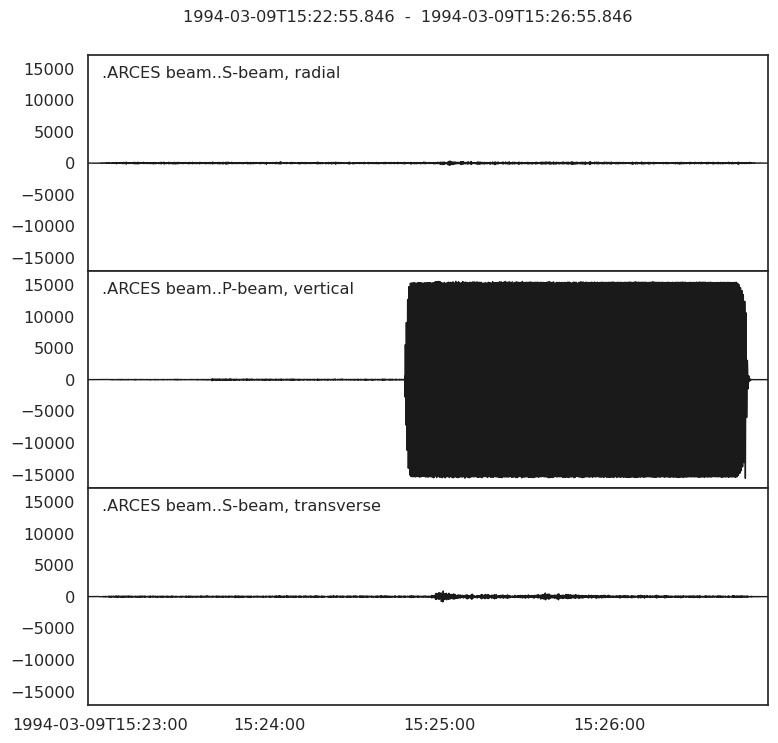

{   'analyst_pick_time': None,
    'az_to_arces': 7.503989927084658,
    'baz_to_arces': 189.92346087857786,
    'dist_to_arces': 791.9444896486827,
    'est_arrivaltime_arces': '1994-03-09 15:23:55.837000',
    'event_type': 'explosion',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.0029042439590940407,
    'magnitude_sqrtdist_ratio': 0.08172980549295521,
    'magnitudes': [   {   'creation_info': {'agency_id': 'HEL'},
                          'mag': 2.3,
                          'magnitude_type': 'MA',
                          'origin_id': 'smi:local/bb03f8b4-f4ab-4b13-a71b-c403bbf4a34b',
                          'resource_id': 'smi:local/f900f408-4d3a-49f4-bdb0-4156c34f81f3',
                          'station_count': 4}],
    'origins': [   {   'creation_info': {'agency_id': 'HEL'},
                       'depth': 0.0,
                       'latitude': 62.508,
                       'latitude_errors': {'uncertainty': 5.1},
                       'longitude

In [24]:
k += 1
print(k)
candidates = [1, 2, 6, 7, 8, 10]
#filter_name = "highpass"
#filter_name = "bandpass"
filter_name = None
band_min = 2
band_max = 8
highpass_freq = 15

explo_path = explo_ds[k][0]
explo_path = '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/1994-03-09T15.22.55.837000Z.h5'
print(explo_path)
trace, info = handler.path_to_trace(explo_path)
trace_bandpass = handler.apply_filter(trace, info, "bandpass", highpass_freq = highpass_freq, band_min = band_min, band_max = band_max)
trace_highpass = handler.apply_filter(trace, info, "bandpass", highpass_freq = highpass_freq, band_min = band_min, band_max = band_max)

print(info['est_arrivaltime_arces'])
print(timeAug.find_initial_event_index(explo_path)[0])
print("ORIGINAL")
helper.plot_event(trace, info)
print("BANDPASS")
helper.plot_event(trace_bandpass, info)
print("HIGHPASS")
helper.plot_event(trace_highpass, info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(info)


#j = j-1


In [28]:
noise_ds = loadData.noise_ds

# Noise

/media/tord/T7/Thesis_ssd/norsar_data_nov/noise/2014-04-08T19.46.46.000000Z.h5 (appears to contain interesting event)

/media/tord/T7/Thesis_ssd/norsar_data_nov/noise/2005-04-15T18.49.35.000000Z.h5 (same as above)

/media/tord/T7/Thesis_ssd/norsar_data_nov/noise/2008-01-13T00.17.44.000000Z.h5


### Events which warrant questions:

 - 

In [29]:
o = 0

96
/media/tord/T7/Thesis_ssd/norsar_data_nov/noise/2018-02-18T19.45.01.000000Z.h5
2018-02-18 19:46:01
2400
ORIGINAL


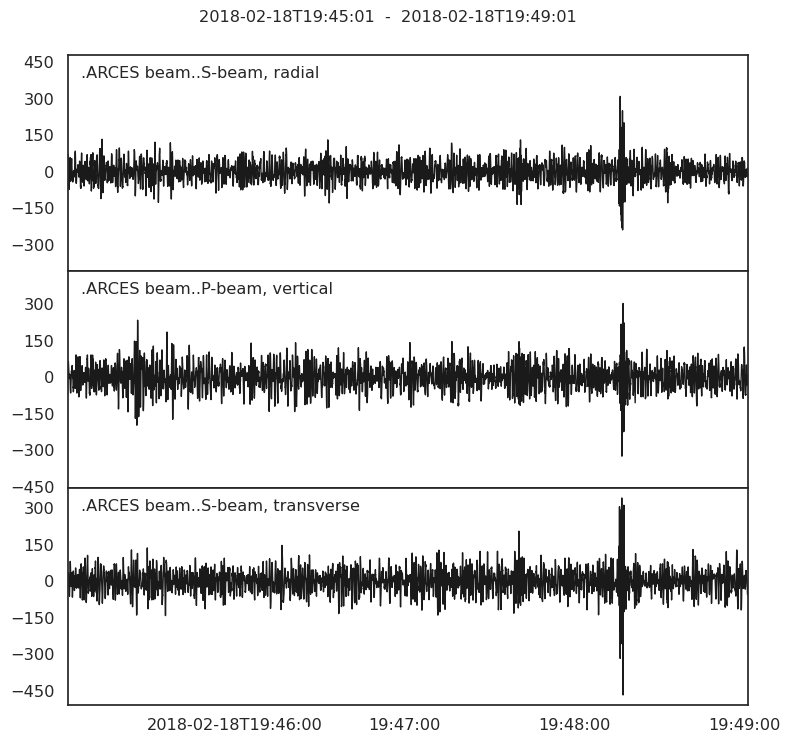

BANDPASS


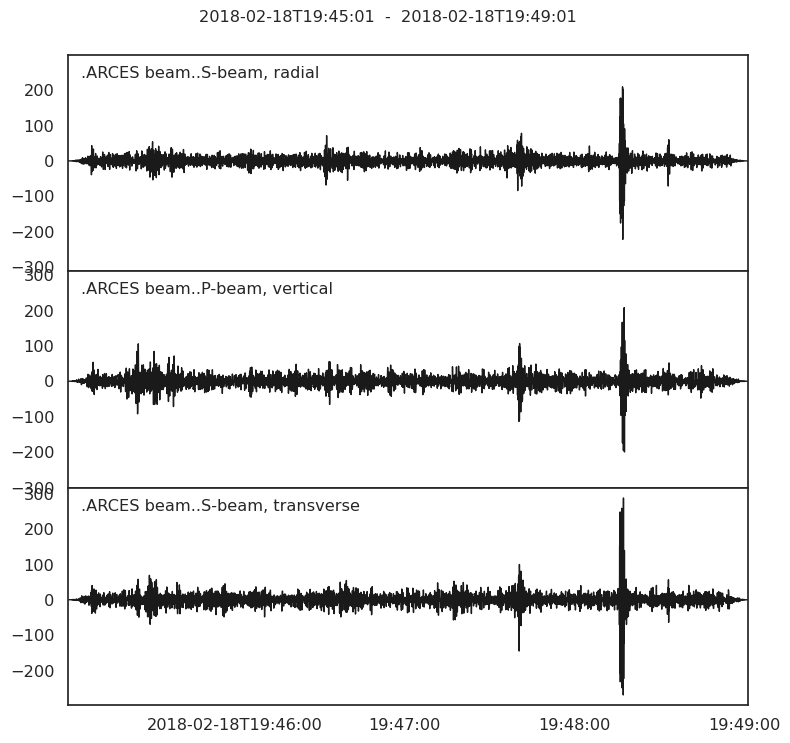

HIGHPASS


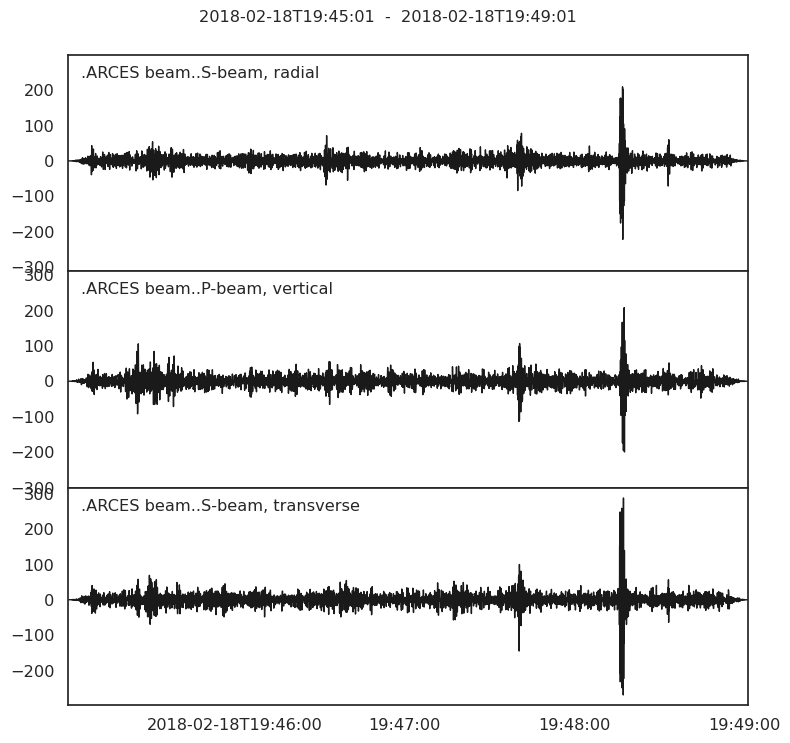

{   'analyst_pick_time': None,
    'baz_to_arces': 6.215855156607791,
    'est_arrivaltime_arces': '2018-02-18 19:46:01',
    'trace_stats': {   'channels': [   'P-beam, vertical',
                                       'S-beam, transverse',
                                       'S-beam, radial'],
                       'sampling_rate': 40.0,
                       'starttime': '2018-02-18T19:45:01.000000Z',
                       'station': 'ARCES beam'}}


In [128]:
o += 1
candidates = [1, 2, 6, 7, 8, 10]
filter_name = "highpass"
band_min = 2
band_max = 8
highpass_freq = 5

print(o)
noise_path = noise_ds[o][0]
#noise_path = '/media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/1993-08-26T19.24.32.293000Z.h5'
print(noise_path)
trace, info = handler.path_to_trace(noise_path)
trace_bandpass = handler.apply_filter(trace, info, "bandpass", highpass_freq = highpass_freq, band_min = band_min, band_max = band_max)
trace_highpass = handler.apply_filter(trace, info, "bandpass", highpass_freq = highpass_freq, band_min = band_min, band_max = band_max)

print(info['est_arrivaltime_arces'])
print(timeAug.find_initial_event_index(noise_path)[0])
print("ORIGINAL")
helper.plot_event(trace, info)
print("BANDPASS")
helper.plot_event(trace_bandpass, info)
print("HIGHPASS")
helper.plot_event(trace_highpass, info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(info)


